In [66]:
import numpy as np
import glob
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Ellipse
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
# Partimos con las variables que vamos a necesitar

H_0 = 7/3e5     # está en unidades de (1/Mpc)
h = 0.7
Omega_m = 0.3

z = 0
d = 1/(1+z)

A_s = 2.31744e-9
f_nl = 10

k_f = 2*np.pi/2000  # k fundamental, que sirve para medir el lado de la caja en espacio de Fourier
delta_k = 3*k_f  # radio de la esfera en espacio de Fourier

num_rea = 15   # número de realizaciones de la medición, en nuestro caso fueron 15 realizaciones

In [3]:
# glob.glob es para que lea la dirección de varios archivos que se encuentran en una carpeta, dependiendo del nombre.
# Aún no lee lo que se encuentra dentro de cada archivo. El asterisco al final del run es para que reemplace ese asterisco por 
# 1, 2, ...
# El sort los ordena por número, primero todos los 1, luego los 2 y así

P_list = np.sort(glob.glob('D:/Documentos/Position_Dependent_PS/Python/Fisher_con_el_parametro_Rpsi_fNL/Halos_Squeezed/bisp_hhh_grid_900_s3_c3_iopen1_z0.00_B1_byagox_gaussian_1536_2Gpc_085_run*.dat'))

In [4]:
# Ahora si tenemos la línea que permite leer los archivos

P_data = [] # matriz donde se guardarán los datos que se encuentren en los diferentes archivos
for i in P_list:
    P_data.append(np.loadtxt(i, unpack=True)) # el unpack entrega los elementos por columna

In [5]:
# los modos, donde k_1 y k_2 son modos cortos y el k_3 es el modo squeezed
# P_data[0][0] lo que hace es que asigna a la variable k_1 los datos del primer archivo (run1) la primera columna de datos de
# ese archivo, que corresponde al k1. Todos los archivos tienen los mismos k1, k2 y k3, por eso elegimos [0], pero pudimos
# haber elegido cualquiera de los 15 archivos
# los momentos están en términos de la frecuencia fundamental, por eso hay que multiplicar por k_fundamental para encontrar el
# modo real

k_1 = P_data[0][0]*k_f 
k_2 = P_data[0][1]*k_f
k_3 = P_data[0][2]*k_f

In [6]:
# En esta celda definiremos el \mu que utilizaremos en la derivada de la función de respuesta respecto a G(k).
# Recordemos que el \mu es un ángulo entre el modo k y el q_3, en nuestro caso sería entre el k_1 y el k_3 respectivamente.
# La fórmula de \mu es \mu = -(\vec{k} \cdot \vec{q_3}) / k*q_3

mu = ((k_2**2 - k_1**2 - k_3**2)/2)/(k_1*k_3)

In [7]:
# En esta celda estamos leyendo el archivo que contiene los datos de la función de transferencia. Y luego hacemos una
# interpolación para poder encontrar el T(k3) más adelante. El [:,0] es para que tome todas las filas de la primera columna

T_list = np.loadtxt('D:/Documentos/Position_Dependent_PS/Python/Fisher_con_el_parametro_Rpsi_fNL/tr_om_03_h_07.dat')

T = interpolate.interp1d(T_list[:,0],T_list[:,1])

In [8]:
# Queremos obtener del P_data los datos que corresponden al P(k1), P(k2) y P(k3), que corresponden a las columnas 4, 5 y 6.
# Para eso creamos tres arrays, cada uno para cada P, donde se guardarán los datos de las 15 realizaciones.
# Creamos una matriz para cada P cuyas dimensiones serán de 15x1552, ya que cada matriz P tendrá 15 cajas pequeñas (que
# corresponden a cada realización) y en cada realización hay 1552 datos para una medición del power spectrum.

num_data = len(P_data[0][0])  # num_data = 1552, ya que es el largo de la primera columna del primer archivo.

P_1 = np.zeros((num_rea,num_data))  # matriz que llenaremos con los datos de cada una de las 15 mediciones
P_2 = np.zeros((num_rea,num_data))
P_3 = np.zeros((num_rea,num_data))

In [9]:
# En esta celda estamos llenando las matrices que creamos anteriormente para cada P. Para cada i que corre desde 0 hasta el 14 
# (15 realizaciones) vamos a tomar todos los datos de la cuarta columna en el caso de P_1, la quinta columna para P_2 y la
# sexta columna para P_3.
# A cada variable P_* le asignamos los 1552 datos de cada medición.

for i in range(num_rea):
    P_1[i,:] = P_data[i][3,:]  # el [3,:] significa que toma todos los datos de la cuarta columna
    P_2[i,:] = P_data[i][4,:]
    P_3[i,:] = P_data[i][5,:]

In [10]:
# Ahora que tenemos nuestros P1, P2 y P3, tenemos que tomar cada dato de cada archivo y promediarlo sobre las 15 realizaciones.
# Por ejemplo, el primer dato de P_1 de cada realización se promedia y se obtiene un número que se guarda en P1_prom, esto para
# cada uno de los 1552 datos. 
# El axis=0 significa que promedia sobre las realizaciones, dando un array de 1552 elementos, si fuera axis=1 promediaría sobre
# los 1552 elementos de cada realización y daría un array de 15 elementos.

P1_prom = np.mean(P_1,axis=0)
P2_prom = np.mean(P_2,axis=0)
P3_prom = np.mean(P_3,axis=0)

In [11]:
# En esta celda tomaremos los valores no repetidos de k_1, y también los valores no repetidos de P1_prom. Solo necesitamos
# interpolar estos arreglos para formar la derivada respecto a f_nl de la función de respuesta encontrada usando teoría de 
# perturbaciones.

k__1 = []
for i in list(k_1):
    if i not in k__1:
        k__1.append(i)

#k__1[1], k__1[2] = k__1[2], k__1[1] # cambio el orden de lo elementos seleccionados para no tener error en la interpolación
        
P1__prom = []
for i in list(P1_prom):
    if i not in P1__prom:
        P1__prom.append(i)
        
#P1__prom[1], P1__prom[2] = P1__prom[2], P1__prom[1] # lo mismo que ocurre con el k__1                                           
    
P = UnivariateSpline(k__1, P1__prom) # interpolación
P_primo = P.derivative() # derivada de la interpolación

In [12]:
# Función de N (ecuación 4.70 del overleaf)
# k_3 es el modo squeezed

def N_t(k_1,k_2,k_3,k_f,delta_k):
    return ((8*(np.pi)**2)*k_1*k_2*k_3*(delta_k)**3)/(k_f)**6

In [13]:
# Función para el M(q_3), retorna un arreglo porque la transfer function es un arreglo

M = T(k_3)*(k_3**2)  #(2*(np.pi**2)*A_s)**(1/2)*

In [30]:
# Fisher 1

def fisher_conG_conR(der_G,der_Gpsi,der_fnl):#,der_covariance):
    Nt = N_t(k_1,k_2,k_3,k_f,delta_k)
    Covariance = np.zeros((num_data,num_data))  # matriz donde se guardarán los datos de la covarianza, su tamaño es de 1552x1552

    for i in range(num_data): 
        Covariance[i][i] = (P3_prom[i]*P1_prom[i]*P2_prom[i])/((k_f**3)*Nt[i]) 
        if k_1[i] == k_2[i]:  # el if es por el factor s_b, que dependiendo del tipo de triángulo toma un valor distinto
            Covariance[i][i] = Covariance[i][i]*2
        else:
            Covariance[i][i] = Covariance[i][i]
    
    
    Cov_inv = np.linalg.inv(Covariance)
    
    trans_fnl = der_fnl.T
    trans_G = der_G.T
    trans_Gpsi = der_Gpsi.T
    len_Gpsi = trans_Gpsi.shape[0]
    len_G = trans_G.shape[0]
    
    
    fisher = np.zeros((len_G+len_Gpsi+1,len_G+len_Gpsi+1))
    
    fisher[0][0] = np.dot(trans_fnl,np.dot(Cov_inv,der_fnl))
    #fisher[0][0] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[0],np.dot(Cov_inv,der_covariance[0]))))
    
    for i in range(1,len_Gpsi+1):
        fisher[0][i] = np.dot(trans_fnl,np.dot(Cov_inv,der_Gpsi[:,i-1]))
        #fisher[0][i] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[0],np.dot(Cov_inv,der_covariance[i]))))
        fisher[i][0] = fisher[0][i]
        
    for i in range(len_Gpsi+1,len_Gpsi+len_G+1):
        fisher[0][i] = np.dot(trans_fnl,np.dot(Cov_inv,der_G[:,i-1-len_Gpsi]))
        #fisher[0][i] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[0],np.dot(Cov_inv,der_covariance[i]))))
        fisher[i][0] = fisher[0][i]
    
    for i in range(1,len_Gpsi+1):
        for j in range(len_Gpsi+1,len_Gpsi+len_G+1):
            fisher[i][j] = np.dot(trans_Gpsi[i-1],np.dot(Cov_inv,der_G[:,j-len_Gpsi-1]))
            #fisher[i][j] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[i],np.dot(Cov_inv,der_covariance[j]))))
            fisher[j][i] = fisher[i][j]
    
    for i in range(1,len_Gpsi+1):
        for j in range(i,len_Gpsi+1):
            fisher[i][j] = np.dot(trans_Gpsi[i-1],np.dot(Cov_inv,der_Gpsi[:,j-1]))
            #fisher[i][j] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[i],np.dot(Cov_inv,der_covariance[j]))))
            if i != j:
                fisher[j][i] = fisher[i][j]    

    for i in range(len_Gpsi+1,len_Gpsi+len_G+1):
        for j in range(i,len_Gpsi+len_G+1):
            fisher[i][j] = np.dot(trans_G[i-len_Gpsi-1],np.dot(Cov_inv,der_G[:,j-len_Gpsi-1]))
            #fisher[i][j] += 0.5*np.trace(np.dot(Cov_inv,np.dot(der_covariance[i],np.dot(Cov_inv,der_covariance[j]))))
            if i != j:
                fisher[j][i] = fisher[i][j]
     
                
    return fisher

In [31]:
# Derivada del observable respecto al parámetro f_nl
# Para cada k, G_psi(k) toma un valor distinto, por lo que tenemos en total 1552 derivada respecto a f_nl

der_fnl = np.zeros((num_data))

for i in range(num_data):
    der_fnl[i] = (4 - (2*mu[i]*k_3[i]*P_primo(k_1[i]))/P(k_1[i]))*(M[i]**(-1))*P1_prom[i]*P3_prom[i]
            
    
# Parametrización de R_psi.
num_pol_R = 2
der_fnl_param = np.zeros((num_data,num_pol_R))

for i in range(num_data):
    for j in range(num_pol_R):
        der_fnl_param[i][j] = (M[i]**(-1))*P1_prom[i]*P3_prom[i] * k_1[i]**j

        
# Parametrización de G(k). 
num_pol_G = 4
der_G_param = np.zeros((num_data,num_pol_G))

for i in range(num_data):
    for j in range(num_pol_G):
        der_G_param[i][j] = (1 + (12/13)*(mu[i]**2 - (1/3)))*P1_prom[i]*P3_prom[i] * k_1[i]**j
        
num_pol_Gfnl = 4
der_Gpsi_param = np.zeros((num_data,num_pol_Gfnl-2))

for i in range(num_data):
    for j in range(num_pol_Gfnl-2):
        der_Gpsi_param[i][j] = (M[i]**(-1))*P1_prom[i]*P3_prom[i] * k_1[i]**(j+2)
        
# Derivada del observable respecto a R_psi cuando este es constante
der_fnl_cte = (4 - (2*mu*k_3*P_primo(k_1))/P(k_1))*(M**(-1))*P1_prom*P3_prom

der_cov_param = np.zeros((num_pol_G+num_pol_Gfnl-1,num_data,num_data))

N_3 = 4*np.pi * (k_3**2) * delta_k/(k_f**3)
#B = 

#for i in range(num_data):
#    for j in range(num_data):
#        if k_3[i] == k_3[j]:
#            pre_factor = (4/N_3) * P_3[i] * ((P_1[i]+P_2[i])/2) * B[j]

In [33]:
fisher = (fisher_conG_conR(der_G_param,der_Gpsi_param,der_fnl))
F = fisher[0][0]
delta_final = np.sqrt(np.linalg.inv(fisher)[0][0])
fisher_inv = np.linalg.inv(fisher)

In [94]:
fisher

array([[7.70816956e+00, 1.32836426e+00, 1.10912695e+00, 6.50979752e+03,
        5.35597384e+03, 4.44915073e+03, 3.72949975e+03],
       [1.32836426e+00, 2.38087963e-01, 2.02311158e-01, 1.14861074e+03,
        9.62791926e+02, 8.13897718e+02, 6.93462790e+02],
       [1.10912695e+00, 2.02311158e-01, 1.73248534e-01, 9.62791926e+02,
        8.13897718e+02, 6.93462790e+02, 5.95152665e+02],
       [6.50979752e+03, 1.14861074e+03, 9.62791926e+02, 1.01314378e+07,
        8.38248432e+06, 6.99654127e+06, 5.88847026e+06],
       [5.35597384e+03, 9.62791926e+02, 8.13897718e+02, 8.38248432e+06,
        6.99654127e+06, 5.88847026e+06, 4.99473732e+06],
       [4.44915073e+03, 8.13897718e+02, 6.93462790e+02, 6.99654127e+06,
        5.88847026e+06, 4.99473732e+06, 4.26763375e+06],
       [3.72949975e+03, 6.93462790e+02, 5.95152665e+02, 5.88847026e+06,
        4.99473732e+06, 4.26763375e+06, 3.67110176e+06]])

In [156]:
fisher[[[0,0],[0,2]],[[2,0],[2,2]]]
#fisher[[2,2],[2,0]]
#fisher[2,2]
#fisher[0:2,0:2]

array([[1.10912695, 7.70816956],
       [1.10912695, 0.17324853]])

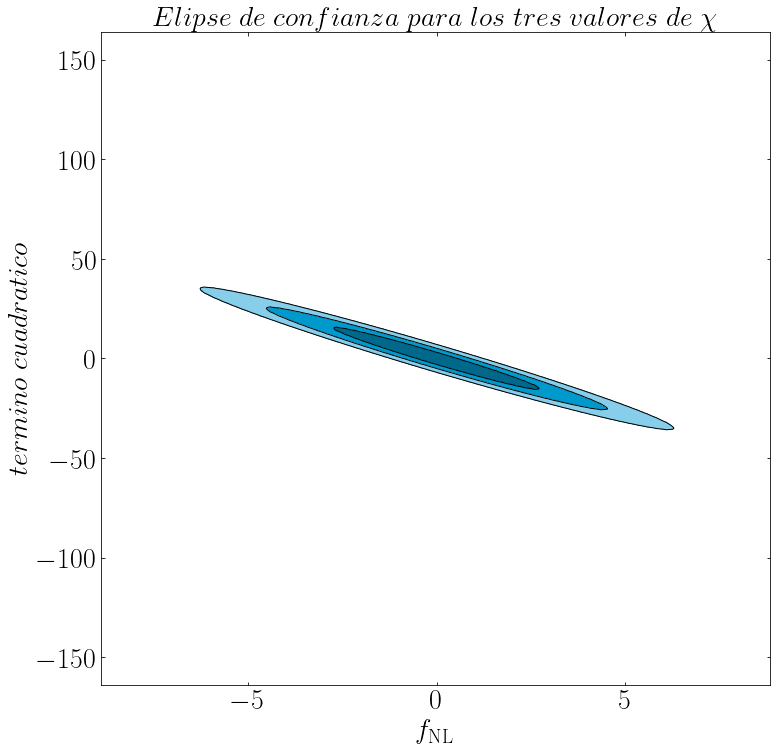

In [167]:
# En esta celda vamos a hacer lo mismo de la celda anterior, es decir, graficar para los tres \chi distintos, pero esta vez
# para la matriz [0:2,0:2], que corresponde al parámetro f_NL y al término cuadrático en G_psi

green1='#125C22'
green2='#238E68'
green3='#32CC99' 
green4='#56DF99' 
green5='#76EEC9'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'
red1='#d62728'#'#cc0000'
red2='#e06666'
red3='#ea9999'
magenta1 = '#DA70D6'
magenta2 = '#9467bd'#'#e377c2'
yellow1 = '#FFD700'
yellow2 = '#FFFF00'

fisher_marginal = fisher[0:2,0:2]
colors = [green1,green2,green3,blue1,blue2,blue3,orange1,orange2,orange3]
fig, ax = plt.subplots(figsize=[12,12])
delta = 0.25
r=0.5

x = np.arange(-r*np.sqrt(fisher_inv[0,0]), r*np.sqrt(fisher_inv[0,0]), delta)
y = np.arange(-r*np.sqrt(fisher_inv[1,1]), r*np.sqrt(fisher_inv[1,1]), delta)

X, Y = np.meshgrid(x, y)
Z = (fisher_marginal[0,0]*(X**2)+ fisher_marginal[1,1]*(Y**2)+ 2*fisher_marginal[0,1]*(X*Y))
CS2 = ax.contourf(X, Y, Z, [0,2.3, 6.17, 11.8], colors=[blue1,blue2,blue3])
ax.contour(X, Y, Z,[0,2.3,6.17,11.8], colors="black",linestyles='solid',linewidths=1 ,alpha=1)

ax.set_xlabel('$f_{\\rm NL}$', fontsize=28)
ax.set_ylabel('$termino\; cuadratico$', fontsize=28)
ax.set_title('$Elipse\; de\; confianza\; para\; los\; tres\; valores\; de\; \chi$', fontsize=28)

plt.tick_params(direction='in',which='both', top = True, right = True,labelsize=28) # tamaño de los números

plt.savefig('D:/Documentos/Position_Dependent_PS/figuraprueba.pdf')
plt.show()

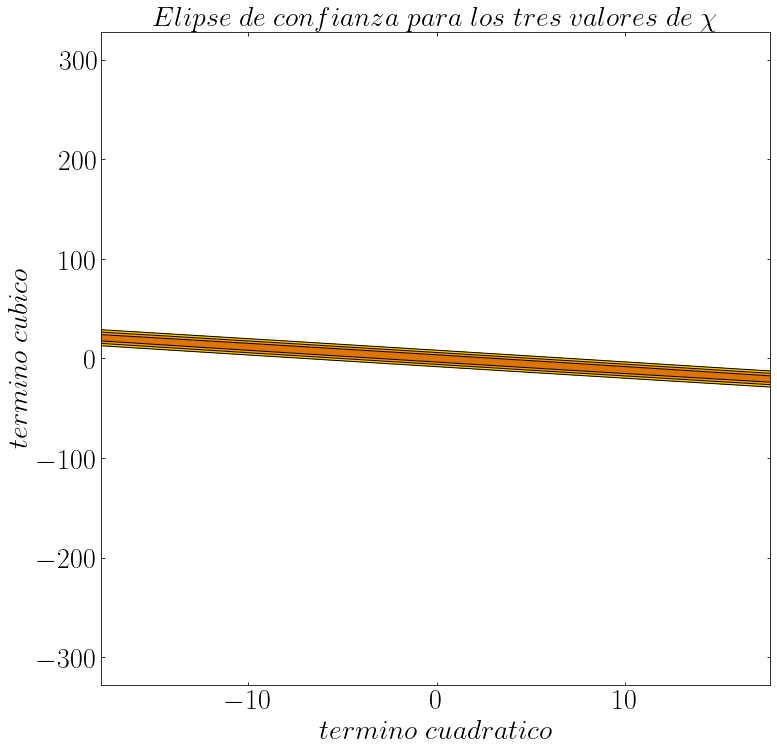

In [166]:
# en esta celda repetimos lo realizados en las dos celdas anteriores, pero esta vez usamos la fisher[1:3,1:3], es decir, 
# el término cuadrático y el cúbico de G_psi

green1='#125C22'
green2='#238E68'
green3='#32CC99' 
green4='#56DF99' 
green5='#76EEC9'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'
red1='#d62728'#'#cc0000'
red2='#e06666'
red3='#ea9999'
magenta1 = '#DA70D6'
magenta2 = '#9467bd'#'#e377c2'
yellow1 = '#FFD700'
yellow2 = '#FFFF00'

fisher_marginal = fisher[1:3,1:3]
colors = [green1,green2,green3,blue1,blue2,blue3,orange1,orange2,orange3]
fig, ax = plt.subplots(figsize=[12,12])
delta = 0.25
r=1

x = np.arange(-r*np.sqrt(fisher_inv[0,0]), r*np.sqrt(fisher_inv[0,0]), delta)
y = np.arange(-r*np.sqrt(fisher_inv[1,1]), r*np.sqrt(fisher_inv[1,1]), delta)

X, Y = np.meshgrid(x, y)
Z = (fisher_marginal[0,0]*(X**2)+ fisher_marginal[1,1]*(Y**2)+ 2*fisher_marginal[0,1]*(X*Y))
CS2 = ax.contourf(X, Y, Z, [0,2.3, 6.17, 11.8], colors=[orange1,orange2,orange3])
ax.contour(X, Y, Z,[0,2.3,6.17,11.8], colors="black",linestyles='solid',linewidths=1 ,alpha=1)

ax.set_xlabel('$termino\; cuadratico$', fontsize=28)
ax.set_ylabel('$termino\; cubico$', fontsize=28)
ax.set_title('$Elipse\; de\; confianza\; para\; los\; tres\; valores\; de\; \chi$', fontsize=28)

plt.tick_params(direction='in',which='both', top = True, right = True,labelsize=28) # tamaño de los números

plt.savefig('D:/Documentos/Position_Dependent_PS/figuraprueba.pdf')
plt.show()

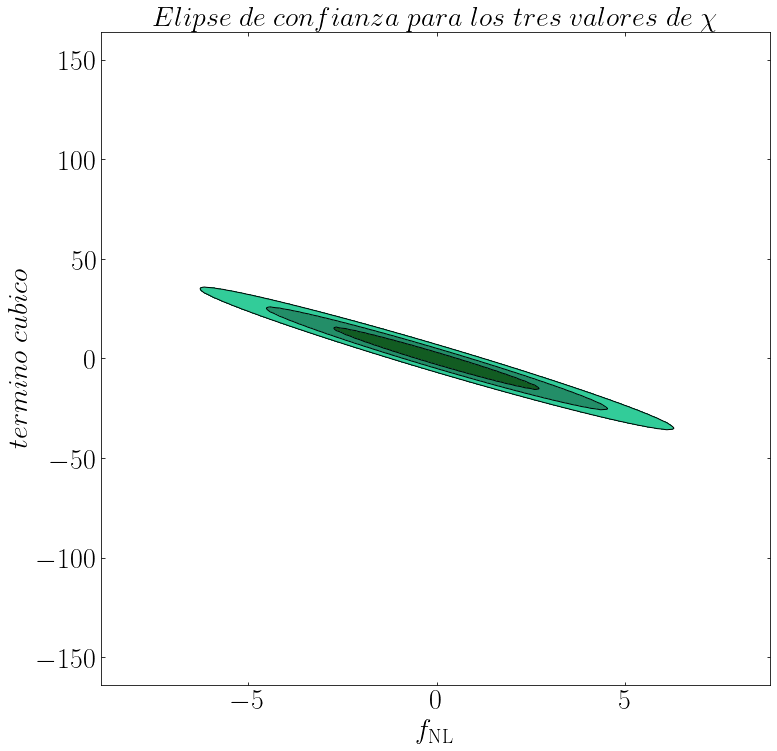

In [165]:
# En esta celda se usa el programa que envió Lina para graficar las elipses. Se grafica para los tres \delta \chi distintos:
# 2.3 ; 6.17 ; 11.8. Queremos los elementos de la Fisher que correspondan a f_nl y al término cúbico de G_psi
# ESTA CELDA HAY QUE ARREGLARLA, LOS ELEMENTOS DE LA FISHER NO CORRESPONDEN CON LO QUE QUEREMOS

green1='#125C22'
green2='#238E68'
green3='#32CC99' 
green4='#56DF99' 
green5='#76EEC9'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'
red1='#d62728'#'#cc0000'
red2='#e06666'
red3='#ea9999'
magenta1 = '#DA70D6'
magenta2 = '#9467bd'#'#e377c2'
yellow1 = '#FFD700'
yellow2 = '#FFFF00'

fisher_marginal = fisher[0:2,:][:,0:2]
colors = [green1,green2,green3,blue1,blue2,blue3,orange1,orange2,orange3]
fig, ax = plt.subplots(figsize=[12,12])
delta = 0.25
r=0.5

x = np.arange(-r*np.sqrt(fisher_inv[0,0]), r*np.sqrt(fisher_inv[0,0]), delta)
y = np.arange(-r*np.sqrt(fisher_inv[1,1]), r*np.sqrt(fisher_inv[1,1]), delta)

X, Y = np.meshgrid(x, y)
Z = (fisher_marginal[0,0]*(X**2)+ fisher_marginal[1,1]*(Y**2)+ 2*fisher_marginal[0,1]*(X*Y))
CS2 = ax.contourf(X, Y, Z, [0,2.3, 6.17, 11.8], colors=[green1,green2,green3])
ax.contour(X, Y, Z,[0,2.3,6.17,11.8], colors="black",linestyles='solid',linewidths=1 ,alpha=1)

ax.set_xlabel('$f_{\\rm NL}$', fontsize=28)
ax.set_ylabel('$termino \; cubico$', fontsize=28)
ax.set_title('$Elipse\; de\; confianza\; para\; los\; tres\; valores\; de\; \chi$', fontsize=28)

plt.tick_params(direction='in',which='both', top = True, right = True,labelsize=28) # tamaño de los números

plt.savefig('D:/Documentos/Position_Dependent_PS/figuraprueba.pdf')
plt.show()

In [17]:
def graficar_elipse(matriz,xmax,ymax,sigma):
    if sigma == 1:
        alfa = 1.52
    elif sigma == 2:
        alfa = 2.48
    elif sigma == 3:
        alfa = 3.44
    else:
        raise ValueError("sigma puede ser solo 1, 2 o 3")
    
    a = alfa*np.sqrt((matriz[0][0] + matriz[1][1])/2 + np.sqrt(((matriz[0][0] - matriz[1][1])**2)/4 + matriz[0][1]**2))
    b = alfa*np.sqrt((matriz[0][0] + matriz[1][1])/2 - np.sqrt(((matriz[0][0] - matriz[1][1])**2)/4 + matriz[0][1]**2))
    
    if matriz[0][0] == matriz[1][1]:
        theta = 0
    else:
        theta = 1/2 * np.arctan(2 * matriz[0][1]/(matriz[0][0] - matriz[1][1]))
    
    ellipse = Ellipse((0,0), width=a, height=b, angle=theta*180/np.pi)
    fig, ax = plt.subplots()
    ax.add_artist(ellipse)
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-ymax, ymax)
    plt.show()

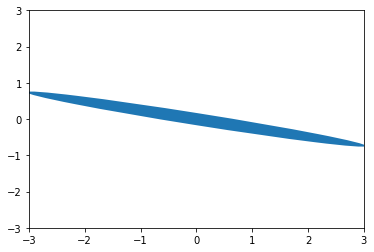

In [20]:
graficar_elipse([[16,-3.9],[-3.9,1]],3,3,1)

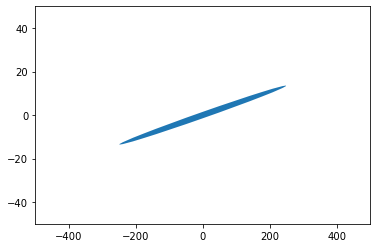

In [21]:
graficar_elipse(fisher_inv[0:2,0:2],500,50,1)

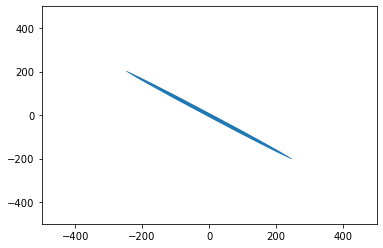

In [22]:
graficar_elipse(fisher_inv[1:3,1:3],500,500,1)

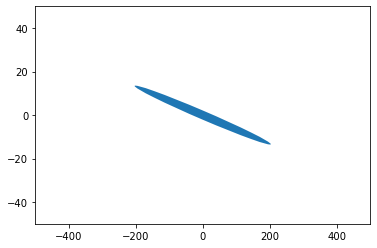

In [23]:
graficar_elipse(fisher_inv[[0,2],:][:,[0,2]],500,50,1)

In [24]:
fisher_inv[[0,2],:][:,[0,2]]

array([[  317.73237386,  4710.52603138],
       [ 4710.52603138, 71592.53514103]])